# PHASE 1: Platform Classification using Supervised Learning Methods - Building Training and Test datasets - paperbot data (part 3 a)

### References:
* https://www.quora.com/What-is-the-best-way-to-create-a-training-set-for-machine-learning/answer/Clem-Wang-1
* http://www.kdnuggets.com/2017/06/acquiring-quality-labeled-training-data.html
* http://www.kdnuggets.com/datasets/index.html
* https://developer.similarweb.com/website_categorization_API
* http://solutionfile.trendmicro.com/solutionfile/Consumer/new-web-classification.html
* http://data.webarchive.org.uk/opendata/ukwa.ds.1/classification/
* https://www.whoisxmlapi.com/blog/moving-beyond-whois-introducing-website-classification-database/
* https://zvelo.com/zvelo-products/zvelos-data-platform-zvelodp/

## Main Python libraries

In [1]:
import os, sys, pathlib
from IPython.display import display, Math, Latex #also '%%latex' magic command
import collections, itertools, operator, re, copy, datetime
import urllib, urllib.request, urllib.parse, dns, ipwhois
import pickle, json, csv, zipfile
import math, random, numpy, scipy, pandas
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import bs4
import nltk, sklearn

#actualcwd = os.getcwd()
#os.chdir(actualcwd)
#print(os.getcwd())

In [2]:
#a simple but not adequate hack to solve:
#-- that this notebook will include any passed module that exists on top of its folder
#-- that my installation of the the nltk will find the correct path to the nlkt_data folder
#
#once this line is run, IT SHOULDN'T RUN AGAIN!, otherwise the cwd will change into something different; 
#it can restored though in different ways, one by using `actualcwd` variable or in some cases shuting down this notebook
#
#
os.chdir('../..')
#print(os.getcwd())
sys.path.append(os.getcwd())
import config.config as config

#print(config.anacondadir)

if os.path.exists(config.anacondadir):
    print('ok')
    nltk.data.path.append(config.anacondadir)

ok


In [3]:
STOP HERE!!

SyntaxError: invalid syntax (<ipython-input-3-bfc7f4b2e6e8>, line 1)

In [4]:
def dataloading(form='', status=''):
    #OBSERVATION!: name of file has been changed to reflect last updated file 
    if pathlib.Path(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv').is_file():
        pd = pandas.read_csv(open(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv', 'r'), sep=';', quotechar="'")
    else:
        print('Not path found')
    print(pd.head(5))
    if 'missing' in pd.columns:
        print(pd.groupby(['missing'])['missing'].count())
        print(pd.loc[pd.missing > 0,:])
    print(pd.shape)
    return pd

def datawikiupdating(pdform):
    import scr.wikipedia_extract
    import imp
    imp.reload(scr.wikipedia_extract)
    pdform['wiki'] = ''
    scr.wikipedia_extract.getting_wikipedia(pdform)
    print(pdform['wiki'][:50])
    
def datasaving(pd, form = 'annotated', status=''):
    if not pathlib.Path(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv').is_file():
        pd.to_csv(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv', sep=';', quotechar="'")
        print('The file : ', form+'platformsphase1_a'+status, 'has been successfully saved. Please check.')
    else:
        accept = input('You are to overwrite the following file : {0}.\nIs that correct?\n'.format(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv'))
        if accept == 'yes':
            pd.to_csv(os.getcwd()+'/data/'+form+'platformsphase1_a'+status+'.csv', sep=';', quotechar="'")
            print('The file has been overwritten. Please check.')
        else:
            print('Overwriting aborted.' )

def datapreparation(pdform):
    import imp
    import scr.datapreparation_ML
    imp.reload(scr.datapreparation_ML)

    def jscheck(x):
        plat = x
        if len(plat.split('.')) > 1:
            if len(plat.split('.')[-2]) > 5:
                if plat.split('.')[-2][-2:] == 'js':
                    return 1
            elif plat.split('.')[0] == 'api':
                return 1

        return 0

    def docscheck(x):
        plat = x
        if len(plat.split('.')) > 1:
            if len(plat.split('.')[0]) > 2:
                if plat.split('.')[0] in ['docs', 'dev', 'developers', 'developer', 'plugins']:
                    return 1
        return 0
    
    def blogscheck(x):
        plat = x
        if len(plat.split('.')) > 1:
            if len(plat.split('.')[0]) > 2:
                if plat.split('.')[0] in ['blog', 'blogs', 'articule', 'articules', 'weblogs', 'weblog']:
                    return 1
        return 0

    def commcheck(x):
        plat = x
        if len(plat.split('.')) > 1:
            if len(plat.split('.')[0]) > 2:
                if plat.split('.')[0] in ['forum', 'forums', 'community', 'channel']:
                    return 1
        return 0

    pdform['alltext'] = ''
    scr.datapreparation_ML.datapreparation(pdform)

    pdform['jscheck'] = None
    pdform['docscheck'] = None
    pdform['blogscheck'] = None
    pdform['commcheck'] = None
    
    pdform['jscheck'] = pdform['platform'].apply(jscheck)
    pdform['docscheck'] = pdform['platform'].apply(docscheck)
    pdform['blogscheck'] = pdform['platform'].apply(blogscheck)
    pdform['commcheck'] = pdform['platform'].apply(commcheck)    
    
    
#ojo to work with local variables:
#https://stackoverflow.com/a/932835/3675901
#locals()["i"]
    
def dataloadandprep(loading=(True,True), status='', increasesizetrain=False, wiki=(False,False), prep=(False,False)):
    '''
    --- loading
    --- form
    --- status: current id of the cycle 
    --- wiki
    --- prep
    --- increasesizetrain
 
    pd_annotated = pdfiles[0]
    pd_notated = pdfiles[1]
 
    '''
    pdfiles = []
    for i, v in enumerate(loading):
        if v:
            if i == 0:
                form = 'annotated'
            else:
                form = 'notated'
            pdfiles.append(dataloading(form,status))
    

    
    if increasesizetrain:
        unform = 'unlabelled'
        if pathlib.Path(os.getcwd()+'/data/'+unform+'platformsphase1_a'+status+'.csv').is_file():
            pd_predaggregate_trans = pandas.read_csv(open(os.getcwd()+'/data/'+unform+'platformsphase1_a'+status+'.csv', 'r'), sep=';', quotechar="'")
            print('Could open ', os.getcwd()+'/data/'+unform+'platformsphase1_a'+status+'.csv', 'successfully')
        else:
            print('Could not open ', os.getcwd()+'/data/'+unform+'platformsphase1_a'+status+'.csv')
            return
        print(pd_predaggregate_trans.columns, pd_predaggregate_trans.shape)
        pd_predaggregate_trans = pd_predaggregate_trans[['platform','category']]
        pd_annotated_trans = pandas.merge(pdfiles[1].drop(['category'],axis=1), pd_predaggregate_trans, on='platform')
        print(pd_annotated_trans.shape, pd_annotated_trans.columns, pd_annotated_trans.category)
        pd_annotated_x = pdfiles[0].loc[:,~pdfiles[0].columns.duplicated()]
        pd_annotated_trans = pd_annotated_trans.loc[:,~pd_annotated_trans.columns.duplicated()]
        pd_annotated_x = pandas.concat([pd_annotated_x,pd_annotated_trans], join='inner', ignore_index=True)
        print(pd_annotated_x.shape, pd_annotated_x.columns)
        accept = input('Would you like to write to file to {0}?\n'.format(os.getcwd()+'/data/annotatedplatformsphase1_a'+str(int(status)+1)+'.csv'))
        if accept.lower() == 'yes':
            pdfiles[0] = pd_annotated_x
            datasaving(pdfiles[0], form = 'annotated', status=str(int(status)+1))
            return
            
        else:
            sys.exit()
    
    for i, v in enumerate(wiki):
        if v:
            datawikiupdating(pdfiles[i])
    
    for i, v in enumerate(prep):
        #for col in pdform.columns:
        #    print(col,' has the following null values: ', pdform[[col]].isnull().sum())
        if v:
            datapreparation(pdfiles[i])
            if i == 0:
                form = 'annotated'
            else:
                form = 'notated'
            datasaving(pdfiles[i], form, status)

    return pdfiles
                

## DATA UPDATING - Important...

The code commented below was used to:
* **Add wikipedia info to the created tables**: for this I used the `scr.wikipedia_extract` module made for this purpose
* **Revise some column naming and use the names for categories** to be used from now on: until now (29-July-17), I was using as categories a regex form I used for the original classification rules; from now I will be using the defined categories found in the `docs` folder of this work

The changes below were done by creating updated files, re-opening that file and update it until the right file was created. Once the information was updated with some information, the respective code was commented because it was not of usage any more.

The code below is kept commented but is shown so other users of this file can have a reference. Also the different intermediate files are kept in the `data` folder but only the required files are called for further analysis. In a more advanced phase a simpler file will be kept.

In [5]:
#pd_errortemp = pd_notated.loc[pd_notated['platform'] == 'view-source:http:',]
#scr.wikipedia_extract.getting_wikipedia(pd_errortemp)
#print(pd_errortemp)
#print(pd_notated.iloc[110,])
#url = 'https://en.wikipedia.org/w/api.php?action=query&list=search&format=json&srsearch=JavaScript Objects in Detail'
#req = urllib.request.Request(url)
#try:
#    resp = urllib.request.urlopen(req)
#except urllib.error.HTTPError as e:
#    print(e)

In [6]:
#pd_annotated = pd_annotated.rename(columns={'category':'category_regex'})

In [7]:
#pd_annotated.columns

In [8]:
#categories = pandas.read_csv(open(os.getcwd()+'/docs/category_operationalization.csv', 'r'), sep=':')

In [9]:
#categories

In [10]:
#categories = categories[['category','category_regex']]

In [11]:
#pd_annotated = pandas.merge(pd_annotated, categories, on=['category_regex'])

In [12]:
#pd_annotated.head(5)

In [13]:
#pd_annotated.to_csv(os.getcwd()+'/data/annotatedplatformsphase1_a1.csv', sep=';', quotechar="'")
#pd_notated.to_csv(os.getcwd()+'/data/notatedplatformsphase1_a2.csv', sep=';', quotechar="'")

In [14]:
STOP HERE!

SyntaxError: invalid syntax (<ipython-input-14-d5af98942240>, line 1)

## DATA PREPARATION

In [15]:
pd_annotated, pd_notated = dataloadandprep(loading=(True,True),
                                           status='7',
                                           increasesizetrain=False,
                                           wiki=(False,False),
                                           prep=(False,True))

   Unnamed: 0  Unnamed: 0.1                   platform  \
0           0             0  v4-alpha.getbootstrap.com   
1           1             1                jscroll.com   
2           2             2             mongoosejs.com   
3           3             3         www.highcharts.com   
4           4             4         www.crossorigin.me   

                                               title  \
0  \n  \n    bootstrap · the most popular html, c...   
1  jscroll - a jquery plugin for infinite scrolli...   
2                               mongoose odm v4.10.5   
3  Interactive JavaScript charts for your webpage...   
4                                     crossorigin.me   

                                         description  \
0  the most popular html, css, and js framework i...   
1                                                      
2                                                      
3  Highcharts - Interactive JavaScript charts for...   
4                                 

In [16]:
STOP HERE!

SyntaxError: invalid syntax (<ipython-input-16-d5af98942240>, line 1)

# ANALYSIS

## UTILITIES

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
def vectorizer(documents):
    countvect = CountVectorizer(ngram_range=(1,2))
    X_counts = countvect.fit_transform(documents)
    return X_counts, countvect

from scipy.sparse import hstack
import copy
def hstacker(X, hackedcolumns):
    X_countsh = hstack((copy.copy(X), hackedcolumns))
    return X_countsh


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
def modelling(Classifier, X, y, params = {}):
    #clf_dtm = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=0)
    clf = Classifier()
    if params != {}:
        clf.set_params(**params)
    return clf, clf.fit(X, y)

def compareyvsypredict(target, y, y_predict):
    print('{0:35} => {1:15} => {2:15}'.format('Target','Class','PredClass'))
    for plat, category in zip(zip(target, y), y_predict):
        print('{0:35} => {1:15} => {2:15}'.format(plat[0], plat[1], category))
    

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
def gridsearchwithprecandrecall(model, X_train, y_train, X_test, y_test, tuned_parameters):
    # Set the parameters by cross-validation
    tuned_parameters = [tuned_parameters]
    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, tuned_parameters, cv=2,
                           scoring='%s_macro' % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_predsearch = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_predsearch))
        print()
    return clf

    
def err(clf_stump, clf_err, X_test, y_test, params={}):
    if params != {}:
        clf_err.set_params(**params)
    clf_stump_err = 1.0 - clf_stump.score(X_test, y_test)
    clf_err = 1.0 - clf_err.score(X_test, y_test)
    print('stump error : {0:.2f}; model error : {1:.2f}'.format(clf_stump_err, clf_err))
    return clf_stump_err, clf_err



#IMPORTANT... https://stackoverflow.com/questions/33110973/pass-a-dict-to-scikit-learn-estimator
#clf_dtm_r2.set_params(**clf.best_params_)
#clf_dt_r2 = clf_dtm_r2.fit(X_primercounts2, train2.category)

from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
def ADA(model, stump_err, mod_err, X_train, y_train, X_test, y_test, n_estimators = 40, learning_rate = 1.):
    ada_discrete = AdaBoostClassifier(
        base_estimator = model,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        algorithm="SAMME")
    ada_discrete.fit(X_train, y_train)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot([1, n_estimators], [stump_err] * 2, 'k-',
            label='Decision Stump Error')
    ax.plot([1, n_estimators], [mod_err] * 2, 'k--',
            label='Decision Tree Error')

    ada_discrete_err = numpy.zeros((n_estimators,))
    for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
        ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

    ada_discrete_err_train = numpy.zeros((n_estimators,))
    for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
        ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

    ax.plot(numpy.arange(n_estimators) + 1, ada_discrete_err,
            label='Discrete AdaBoost Test Error',
            color='red')
    ax.plot(numpy.arange(n_estimators) + 1, ada_discrete_err_train,
            label='Discrete AdaBoost Train Error',
            color='blue')

    ax.set_ylim((0.0, 1.0))
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('error rate')

    leg = ax.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.7)

    plt.show()
    return ada_discrete


def decisiontreeanalysis(X_train,  X_trainh, y_train, X_test, X_testh, y_test):
    slump_params = {'max_depth':1, 'min_samples_leaf':1, 'random_state':0}
    mod_params = {'min_samples_leaf':2, 'random_state':0}

    clf_dt_slump, dt_fit_slump = modelling(DecisionTreeClassifier, X_train, y_train, slump_params)
    clf_dt_mod, dt_fit = modelling(DecisionTreeClassifier, X_train, y_train, mod_params)

    clf_dt_slumph, dt_fit_slumph = modelling(DecisionTreeClassifier, X_trainh, y_train, slump_params)
    clf_dt_modh, dt_fith = modelling(DecisionTreeClassifier, X_trainh, y_train, mod_params)
    
    tuned_parameters = {'max_depth': numpy.arange(5,25,2)}
    gs_clf_dt_mod = gridsearchwithprecandrecall(clf_dt_mod, X_train, y_train, X_test, y_test, tuned_parameters)
    gs_clf_dt_modh = gridsearchwithprecandrecall(clf_dt_modh, X_trainh, y_train, X_testh, y_test, tuned_parameters)
    
    clf_dt_stump_err, clf_dt_mod_err = err(clf_dt_slump, clf_dt_mod, X_test, y_test, gs_clf_dt_mod.best_params_)
    clf_dt_stump_errh, clf_dt_mod_errh = err(clf_dt_slumph, clf_dt_modh, X_testh, y_test, gs_clf_dt_modh.best_params_)
    
    return clf_dt_slump, dt_fit_slump, clf_dt_mod, dt_fit, clf_dt_slumph, dt_fit_slumph, clf_dt_modh, dt_fith, gs_clf_dt_mod, gs_clf_dt_modh, clf_dt_stump_err, clf_dt_mod_err, clf_dt_stump_errh, clf_dt_mod_errh



def supportvectormachineanalysis(X_train,  X_trainh, y_train, X_test, X_testh, y_test):
    slump_params = {'C':1.}
    clf_svc_slump, svc_fit_slump = modelling(svm.LinearSVC, X_train, y_train, slump_params)
    clf_svc_mod, svc_fit = modelling(svm.LinearSVC, X_train, y_train)

    clf_svc_slumph, svc_fit_slumph = modelling(svm.LinearSVC, X_trainh, y_train, slump_params)
    clf_svc_modh, svc_fith = modelling(svm.LinearSVC, X_trainh, y_train)

    tuned_parameters = {'C': numpy.arange(.1,1,.1)}
    gs_clf_svc_mod = gridsearchwithprecandrecall(clf_svc_mod, X_train, y_train, X_test, y_test, tuned_parameters)
    gs_clf_svc_modh = gridsearchwithprecandrecall(clf_svc_modh, X_trainh, y_train, X_testh, y_test, tuned_parameters)
    clf_svc_stump_err, clf_svc_mod_err = err(clf_svc_slump, clf_svc_mod, X_test, y_test, gs_clf_svc_mod.best_params_)
    clf_svc_stump_errh, clf_svc_mod_errh = err(clf_svc_slumph, clf_svc_modh, X_testh, y_test, gs_clf_svc_modh.best_params_)

    return clf_svc_slump, svc_fit_slump, clf_svc_mod, svc_fit, clf_svc_slumph, svc_fit_slumph, clf_svc_modh, svc_fith, gs_clf_svc_mod, gs_clf_svc_modh, clf_svc_stump_err, clf_svc_mod_err, clf_svc_stump_errh, clf_svc_mod_errh



from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn import preprocessing

def cossim(train,tst,countmod,compare=True):
    '''
    tst : any test file added
    reference:
    --- https://stackoverflow.com/questions/14808945/check-if-variable-is-dataframe
    '''
    #print(tst.shape)
    le = preprocessing.LabelEncoder()
    le.fit(train['category'])
    print(le.classes_)
    models = {}
    for les in le.classes_:
        yes = ' '.join(train.loc[train['category']==les,'alltext'])
        no  = ' '.join(train.loc[train['category']!=les,'alltext'])
        models[les] = (countmod.transform([yes]), countmod.transform([no]))
    
    quickanal = []
    assigneds = []
    for rec in tst.loc[:,['category','alltext']].iterrows():
        m = countmod.transform([rec[1].alltext])
        vals = []
        for les in le.classes_:
            vals.append(cosine_similarity(m, models[les][0]))
        index = vals.index(max(vals))
        assigned = le.classes_[index]
        #print('Category was {0}; Assigned was {1} (cosine_sim : {2:.2f})'.format(rec[1].category,assigned,max(vals)))
        if compare:
            print('cosine similary ',rec[1].category,assigned,max(vals))
            if rec[1].category == assigned:
                quickanal.append(1)
            else:
                quickanal.append(0)
        assigneds.append(assigned)
        #break
    
    if compare:
        print(sum(quickanal)/len(quickanal))
        print(classification_report(tst['category'], assigneds))
    
    return assigneds



def aggregatesclasses(test, X_test, X_testh, y_test, clf_adadt_mod, clf_dt_modh, clf_svc_modh, assigneds, compare = True):    
    
    def funcfact(func, args):
        return func.predict(**args)
    
    def classagg(x):
        if x.pred_dtada == x.pred_dth == x.pred_svch and x.pred_dth != 'TRAINING':
            return x.pred_dtada
        return x.pred_svch

    def classagg1(x):
        if x.pred_dth == x.pred_svch and x.pred_dth != 'TRAINING':
            return x.pred_dth
        if x.pred_dtada == x.pred_dth and x.pred_dth != 'TRAINING':
            return x.pred_dtada
        if x.pred_dtada == x.pred_svch and x.pred_dth != 'TRAINING':
            return x.pred_dtada
        return x.pred_svch

    def classagg2(x):
        if x.pred_dth == x.pred_svch and x.pred_dth != 'TRAINING':
            return x.pred_dth
        if x.pred_dtada == x.pred_dth and x.pred_dth != 'TRAINING':
            return x.pred_dtada
        if x.pred_dtada == x.pred_svch and x.pred_dth != 'TRAINING':
            return x.pred_dtada
        return x.pred_dth

    def classagg3(x):
        def value(args):
            cv = args[0]
            maxim = len(args)
            val = 1
            for i in args[1:]:
                if cv == i:
                    val += 1
                else:
                    break
            if val == maxim:
                return True
            else:
                return False
        
        if x.cossim in ['DOCS','REPL','BUSINESS','ECOMMERCE','COMMUITY','SENGINE','PAAS'] and not value([x.pred_dtada, x.pred_dth, x.pred_svch]):
            return x.cossim

        if x.pred_dth == x.cossim in ['TRAINING','NEWS','PACKAGE','NOCLASS','THEME']:
            return x.pred_dth

        #if x.pred_dtada == x.pred_dth == x.pred_svch == x.cossim and x.pred_dth != 'TRAINING':
        if x.pred_dtada == x.pred_dth == x.pred_svch == x.cossim:
            return x.pred_dtada

        return x.pred_dth
    
    if compare:
        pd_predaggregate = pandas.DataFrame({'platform':test.platform, 'category':y_test, 'pred_dtada':clf_adadt_mod.predict(X_test), 'pred_dth':clf_dt_modh.predict(X_testh), 'pred_svch':clf_svc_modh.predict(X_testh), 'cossim':assigneds})
    
        print('pred_dtada')
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_dtada']))
        print('pred_dth')
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_dth']))
        print('pred_svch')
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_svch']))
        print('cossim')
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['cossim']))
        print('pred_agg1')
        pd_predaggregate['pred_agg1'] = ''
        pd_predaggregate['pred_agg1'] = pd_predaggregate.apply(classagg1, axis=1)
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_agg1']))
        print('pred_agg2')
        pd_predaggregate['pred_agg2'] = ''
        pd_predaggregate['pred_agg2'] = pd_predaggregate.apply(classagg2, axis=1)        
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_agg2']))
        print('pred_agg3')
        pd_predaggregate['pred_agg3'] = ''
        pd_predaggregate['pred_agg3'] = pd_predaggregate.apply(classagg3, axis=1)           
        print(classification_report(pd_predaggregate['category'], pd_predaggregate['pred_agg3']))
        return None
    
    else:
        print(len(test.platform), len(clf_adadt_mod.predict(X_test)), len(clf_dt_modh.predict(X_testh)), len(clf_svc_modh.predict(X_testh)), len(assigneds))
        pd_predaggregate = pandas.DataFrame({'platform':test.platform, 'pred_dtada':clf_adadt_mod.predict(X_test), 'pred_dth':clf_dt_modh.predict(X_testh), 'pred_svch':clf_svc_modh.predict(X_testh), 'cossim':assigneds})
        pd_predaggregate['pred_agg1'] = ''
        pd_predaggregate['pred_agg1'] = pd_predaggregate.apply(classagg1, axis=1)
        pd_predaggregate['pred_agg2'] = ''
        pd_predaggregate['pred_agg2'] = pd_predaggregate.apply(classagg2, axis=1)   
        pd_predaggregate['pred_agg3'] = ''
        pd_predaggregate['pred_agg3'] = pd_predaggregate.apply(classagg3, axis=1)   
        return pd_predaggregate



In [18]:
STOP HERE!

SyntaxError: invalid syntax (<ipython-input-18-d5af98942240>, line 1)

In [19]:
def datafullprocessing(pdfiles, nextstatus = '', create_unlab = False):
    '''
    pd_anndata = pdfiles[0]
    pd_noandata = pdfiles[1]
    '''
    train=pdfiles[0][['platform', 'alltext', 'jscheck', 'docscheck', 'blogscheck', 'commcheck', 'category']].sample(frac=0.75)
    test=pdfiles[0][['platform', 'alltext','jscheck', 'docscheck', 'blogscheck', 'commcheck', 'category']].drop(train.index)
    X_train, countmod = vectorizer(train.alltext)
    X_trainh = hstacker(X_train, train[['jscheck', 'docscheck', 'blogscheck', 'commcheck']])
    y_train = train.category
    def testf(test):
        X_test = countmod.transform(test.alltext)
        X_testh = hstacker(X_test, test[['jscheck', 'docscheck', 'blogscheck', 'commcheck']])
        y_test = test.category
        return X_test, X_testh, y_test
    X_test, X_testh, y_test = testf(test)
    if create_unlab:
        unltest = pdfiles[1][['platform', 'alltext', 'jscheck', 'docscheck', 'blogscheck', 'commcheck', 'category']]
        X_unltest, X_unltesth, y_unltest = testf(unltest)

    ##decision tree
    clf_dt_slump, dt_fit_slump, clf_dt_mod, dt_fit, clf_dt_slumph, dt_fit_slumph, clf_dt_modh, dt_fith, gs_clf_dt_mod, gs_clf_dt_modh, clf_dt_stump_err, clf_dt_mod_err, clf_dt_stump_errh, clf_dt_mod_errh = decisiontreeanalysis(X_train,  X_trainh, y_train, X_test, X_testh, y_test)

    ##adaboost for decision tree
    clf_adadt_mod = ADA(clf_dt_mod, clf_dt_stump_err, clf_dt_mod_err, X_train, y_train, X_test, y_test, n_estimators = 40, learning_rate = .5)
    clf_adadt_modh = ADA(clf_dt_modh, clf_dt_stump_errh, clf_dt_mod_errh, X_trainh, y_train, X_testh, y_test, n_estimators = 40, learning_rate = .5)
    
    ##linear support vector machine
    clf_svc_slump, svc_fit_slump, clf_svc_mod, svc_fit, clf_svc_slumph, svc_fit_slumph, clf_svc_modh, svc_fith, gs_clf_svc_mod, gs_clf_svc_modh, clf_svc_stump_err, clf_svc_mod_err, clf_svc_stump_errh, clf_svc_mod_errh = supportvectormachineanalysis(X_train,  X_trainh, y_train, X_test, X_testh, y_test)
    
    assigneds = cossim(train, test, countmod)

    aggregatesclasses(test, X_test, X_testh, y_test, clf_adadt_mod, clf_dt_modh, clf_svc_modh, assigneds)
    
    if create_unlab:
        print('This is shape of unlabelled ', unltest.shape)
        unlassigneds = cossim(train, unltest, countmod, compare=False)
        unlabelled = aggregatesclasses(unltest, X_unltest, X_unltesth, None, clf_adadt_mod, clf_dt_modh, clf_svc_modh, unlassigneds, compare=False)
        print('unlabelled')
        print(unlabelled)
        datasaving(unlabelled, form = 'unlabelled', status = nextstatus)
        

## DATA ANALYSIS 1

## CAPTURING NOTANNOTATED DATA FOR THE FIRST TIME

### Collecting the data and overwriting the nonannotated data with new details (wiki + prepr.)

In [ ]:
pdfiles = dataloadandprep(loading=(True,True),
                status='7',
                increasesizetrain=False,
                wiki=(False,False),
                prep=(False,True))

## CREATE NEXT UNLABELLED FILE

In [ ]:
datafullprocessing(pdfiles, nextstatus = '8', create_unlab = True)

In [ ]:
datafullprocessing([pd_annotated, pd_notated], create_unlab = False)

# ROUND 2

## POST- MANUAL LABELLING

### Increasing the size of the annotated file

In [20]:
dataloadandprep(loading=(True,True),
                status='7',
                increasesizetrain=True,
                wiki=(False,False),
                prep=(False,False))

   Unnamed: 0  Unnamed: 0.1                   platform  \
0           0             0  v4-alpha.getbootstrap.com   
1           1             1                jscroll.com   
2           2             2             mongoosejs.com   
3           3             3         www.highcharts.com   
4           4             4         www.crossorigin.me   

                                               title  \
0  \n  \n    bootstrap · the most popular html, c...   
1  jscroll - a jquery plugin for infinite scrolli...   
2                               mongoose odm v4.10.5   
3  Interactive JavaScript charts for your webpage...   
4                                     crossorigin.me   

                                         description  \
0  the most popular html, css, and js framework i...   
1                                                      
2                                                      
3  Highcharts - Interactive JavaScript charts for...   
4                                 

### Re-analysis of the extended annotated file and modelling

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1                   platform  \
0           0             0             0  v4-alpha.getbootstrap.com   
1           1             1             1                jscroll.com   
2           2             2             2             mongoosejs.com   
3           3             3             3         www.highcharts.com   
4           4             4             4         www.crossorigin.me   

                                               title  \
0  \n  \n    bootstrap · the most popular html, c...   
1  jscroll - a jquery plugin for infinite scrolli...   
2                               mongoose odm v4.10.5   
3  Interactive JavaScript charts for your webpage...   
4                                     crossorigin.me   

                                         description  \
0  the most popular html, css, and js framework i...   
1                                                      
2                                                      
3  Hig

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/sit

Best parameters set found on development set:

{'max_depth': 17}

Grid scores on development set:

0.154 (+/-0.072) for {'max_depth': 5}
0.146 (+/-0.069) for {'max_depth': 7}
0.202 (+/-0.032) for {'max_depth': 9}
0.219 (+/-0.050) for {'max_depth': 11}
0.205 (+/-0.008) for {'max_depth': 13}
0.201 (+/-0.024) for {'max_depth': 15}
0.237 (+/-0.077) for {'max_depth': 17}
0.218 (+/-0.065) for {'max_depth': 19}
0.228 (+/-0.030) for {'max_depth': 21}
0.227 (+/-0.033) for {'max_depth': 23}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   BUSINESS       0.00      0.00      0.00         9
   COMMUITY       0.00      0.00      0.00         3
       DOCS       0.33      0.21      0.26        14
  ECOMMERCE       0.00      0.00      0.00         1
       NEWS       0.64      0.54      0.59       114
    NOCLASS       0.22      0.17      0.19        24
     

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/

Best parameters set found on development set:

{'max_depth': 11}

Grid scores on development set:

0.155 (+/-0.017) for {'max_depth': 5}
0.200 (+/-0.005) for {'max_depth': 7}
0.198 (+/-0.000) for {'max_depth': 9}
0.261 (+/-0.091) for {'max_depth': 11}
0.257 (+/-0.066) for {'max_depth': 13}
0.224 (+/-0.063) for {'max_depth': 15}
0.261 (+/-0.047) for {'max_depth': 17}
0.232 (+/-0.026) for {'max_depth': 19}
0.260 (+/-0.041) for {'max_depth': 21}
0.253 (+/-0.005) for {'max_depth': 23}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   BUSINESS       0.00      0.00      0.00         9
   COMMUITY       0.00      0.00      0.00         3
       DOCS       0.71      0.36      0.48        14
  ECOMMERCE       0.00      0.00      0.00         1
       NEWS       0.72      0.61      0.66       114
    NOCLASS       0.33      0.04      0.07        24
     

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'max_depth': 23}

Grid scores on development set:

0.146 (+/-0.045) for {'max_depth': 5}
0.166 (+/-0.052) for {'max_depth': 7}
0.179 (+/-0.020) for {'max_depth': 9}
0.188 (+/-0.010) for {'max_depth': 11}
0.191 (+/-0.009) for {'max_depth': 13}
0.190 (+/-0.037) for {'max_depth': 15}
0.175 (+/-0.038) for {'max_depth': 17}
0.178 (+/-0.063) for {'max_depth': 19}
0.191 (+/-0.024) for {'max_depth': 21}
0.192 (+/-0.049) for {'max_depth': 23}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   BUSINESS       0.05      0.11      0.07         9
   COMMUITY       0.00      0.00      0.00         3
       DOCS       0.56      0.36      0.43        14
  ECOMMERCE       0.00      0.00      0.00         1
       NEWS       0.74      0.61      0.67       114
    NOCLASS       0.20      0.04      0.07        24
     

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


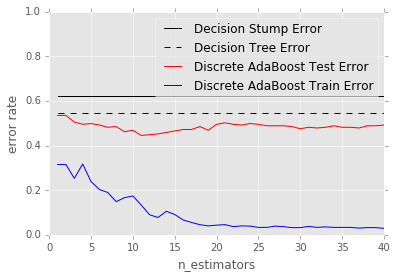

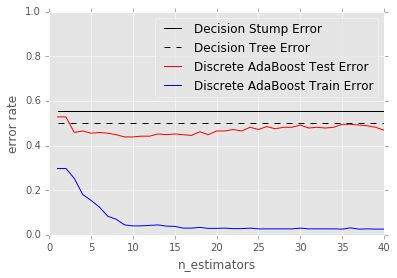

# Tuning hyper-parameters for precision



/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/sit

Best parameters set found on development set:

{'C': 0.20000000000000001}

Grid scores on development set:

0.301 (+/-0.064) for {'C': 0.10000000000000001}
0.309 (+/-0.003) for {'C': 0.20000000000000001}
0.298 (+/-0.013) for {'C': 0.30000000000000004}
0.289 (+/-0.006) for {'C': 0.40000000000000002}
0.288 (+/-0.019) for {'C': 0.5}
0.279 (+/-0.010) for {'C': 0.59999999999999998}
0.276 (+/-0.017) for {'C': 0.70000000000000007}
0.240 (+/-0.069) for {'C': 0.80000000000000004}
0.236 (+/-0.068) for {'C': 0.90000000000000002}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   BUSINESS       0.00      0.00      0.00         9
   COMMUITY       0.00      0.00      0.00         3
       DOCS       0.50      0.07      0.12        14
  ECOMMERCE       0.00      0.00      0.00         1
       NEWS       0.63      0.79      0.70       114
    NOCLASS       0.

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec/anaconda3/lib/

Best parameters set found on development set:

{'C': 0.10000000000000001}

Grid scores on development set:

0.315 (+/-0.079) for {'C': 0.10000000000000001}
0.297 (+/-0.062) for {'C': 0.20000000000000001}
0.296 (+/-0.058) for {'C': 0.30000000000000004}
0.294 (+/-0.074) for {'C': 0.40000000000000002}
0.295 (+/-0.070) for {'C': 0.5}
0.289 (+/-0.067) for {'C': 0.59999999999999998}
0.287 (+/-0.058) for {'C': 0.70000000000000007}
0.285 (+/-0.065) for {'C': 0.80000000000000004}
0.281 (+/-0.062) for {'C': 0.90000000000000002}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

   BUSINESS       0.00      0.00      0.00         9
   COMMUITY       0.00      0.00      0.00         3
       DOCS       1.00      0.36      0.53        14
  ECOMMERCE       0.00      0.00      0.00         1
       NEWS       0.63      0.79      0.70       114
    NOCLASS       0.

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cosine similary  PACKAGE PACKAGE [[ 0.15292236]]
cosine similary  PACKAGE BUSINESS [[ 0.]]
cosine similary  PACKAGE NEWS [[ 0.18665926]]
cosine similary  PACKAGE PACKAGE [[ 0.15050482]]
cosine similary  PACKAGE PACKAGE [[ 0.27550884]]
cosine similary  PACKAGE PACKAGE [[ 0.13750263]]
cosine similary  PACKAGE PACKAGE [[ 0.23616746]]
cosine similary  PACKAGE PACKAGE [[ 0.3018179]]
cosine similary  DOCS NEWS [[ 0.21561755]]
cosine similary  PACKAGE PACKAGE [[ 0.23270578]]
cosine similary  PACKAGE PACKAGE [[ 0.2130209]]
cosine similary  PACKAGE PACKAGE [[ 0.18036792]]
cosine similary  PACKAGE PACKAGE [[ 0.1816625]]
cosine similary  PACKAGE PACKAGE [[ 0.19153052]]
cosine similary  PACKAGE PACKAGE [[ 0.24391117]]
cosine similary  PACKAGE PACKAGE [[ 0.14628385]]
cosine similary  PACKAGE PACKAGE [[ 0.20906583]]
cosine similary  PACKAGE PACKAGE [[ 0.14870176]]
cosine similary  PACKAGE PACKAGE [[ 0.27310892]]
cosine similary  PACKAGE PACKAGE [[ 0.12480985]]
cosine similary  PACKAGE NEWS [[ 0.2471

/home/ec/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
pdfiles = dataloadandprep(loading=(True,False),
                status='8',
                increasesizetrain=False,
                wiki=(False,False),
                prep=(False,False))

datafullprocessing(pdfiles, create_unlab = False)